To Dos:
- Add sigma, phi and tau to optimization
  - How to draw from negative binomial with negative phi?
  - Tau as value to initialize y
  - why does sigma have a gradient of 0?
- Change loss function to negative log likelihood
- Toy Data
- Add prior knowledge to loss function
- Optimize for loops
- Check .clone() - Where do we need it and where is it redundant?



Haomann: Neg. Log Likelihood & Phi Variable
Anuar: Toy Data & Tau Variable
Timo: Sigma Variable

__This notebook is an approach proposed by Haoman to add NLL et Neg. Binomial distribution up on yt__


In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncexpon, truncnorm, nbinom
import pandas as pd
import torch
from torch import nn

In [2]:
np.random.seed(seed=101)
torch.manual_seed(101)
torch.use_deterministic_algorithms(True)
dtype = torch.float
device = torch.device("cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd /content/drive/MyDrive/CovidPrediction/

/content/drive/MyDrive/CovidPrediction


# Initialization

In [5]:
data = pd.read_csv('data/covid19model.csv')
data.head(3)

,date,hospit,serial_interval,delay_distr
0,2020-02-17,0,0.046535,0.013006
1,2020-02-18,0,0.087065,0.030046
2,2020-02-19,0,0.112061,0.044674


In [6]:
cero = torch.tensor(0, requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)

Initialize latent variables / parameters

In [7]:
tau = np.random.exponential(1 / 0.03)
#tau_t = torch.tensor(tau, requires_grad=True, device=device, dtype=dtype)
# b=(upper-lower)/scale, loc=lower, scale=scale
y = torch.tensor(truncexpon.rvs(b=(1000 - 0) / tau, loc=0, scale=tau), requires_grad=False, device=device, dtype=dtype)  # number of initial newly_infected (seed)

# For trunc ((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
#phi = torch.tensor(truncnorm.rvs((0 - 0) / 5, (np.inf - 0) / 5, loc=0, scale=5), requires_grad=True, device=device, dtype=dtype)  # dispersion (shape) parameter for observations
R0 = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True, device=device, dtype=dtype)  # initial reproduction number
alpha = torch.tensor(truncnorm.rvs((0 - 1/100) / 1/100, (5/100 - 1/100) / 1/100, loc=1/100, scale=1/100), requires_grad=True, device=device, dtype=dtype)  # probability to get hospitalized
sigma = torch.tensor(truncnorm.rvs((0 - 0.05) / 0.03, (0.15 - 0.05) / 0.03, loc=0.05, scale=0.03), requires_grad=True, device=device, dtype=dtype)  # standart deviation of random walk step

__From Andreas' model__

"""
(model::Covid19Model)(θ) returns the log loglikelihood of our model with
respect to the parameters θ together with inferred values of 'Rt' and
'expected_daily_hospit'.

In a 'standard' machine learning model the loss function is something like
loss(y,ŷ,θ) = sum( (y-ŷ)^2 ) + α*θ,
where 'y' is the observed outcome, 'ŷ' is the model estimate and α is some
regularisation parameter.

In a Bayesian framework the first term is called the log loglikelihood of the
data wrt. the model and the regularisation term is the log likelihood of our
parameters θ wrt. the prior.

The 'standard' loss function is a special case of the Bayesian approach which
assumes Gaussian distribtions.
"""

function evaluate(model::Covid19Model, θ)
	@unpack τ, y, ϕ, R0, α, σ, ϵt = θ
	@unpack num_obs, num_impute, observed_hospit, i2h, pop, si = model
    ℓ = 0. #likelihood

	# log likelihood wrt. our prior ("regularisation")
	ℓ += logpdf( Exponential(1 / 0.03), τ)
	T = typeof(τ)
	ℓ += logpdf( truncated(Exponential(τ), T(0), T(1000)), y) # number of initial newly_infected (seed)
	ℓ += logpdf( truncated(Normal(25, 5), 0, Inf), ϕ) # dispersion (shape) parameter for observations
	ℓ += logpdf( truncated(Normal(3.6, 0.8), 2, 5), R0) # initial reproduction number
	ℓ += logpdf( truncated(Normal(1/100,1/100), 0,5/100), α) # probability to get hospitalized
	ℓ += logpdf( truncated(Normal(0.05, 0.03), 0, 0.15), σ) # standart deviation of random walk step

# Define Forward Pass

In [8]:
def forward_pass():

  # Initialize time series variables
  newly_infected = torch.zeros(num_observations)  # number of newly infected
  effectively_infectious = torch.zeros(num_observations)  # effective number of infectious individuals
  expected_daily_hospit = torch.zeros(num_observations)  # expected number of daily hospitalizations
  cumulative_infected = torch.zeros(num_observations)  # cumulative number of infected
  eta_t = torch.zeros(num_observations)  # transformed reproduction number
  epsilon_t = torch.zeros(num_observations)  # random walk
  St = torch.zeros(num_observations)  # fraction of susceptible population

  # seed initial infection / impute first num_impute days
  newly_infected[0:num_impute] = y.clone()
  cumulative_infected[0] = 0.
  cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
  St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in cumulative_infected[0:num_impute].clone()])

  # calculate Rt: the basic reproduction number
  beta_0 = torch.log(R0)
  epsilon_t[0] = torch.distributions.Normal(cero, sigma).rsample()
  for t in range(1, num_observations):
      epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].clone(), sigma).rsample()
  eta_t = beta_0 + epsilon_t  # + RNN[X_t, t]  # .clone() necessary?
  Rt = torch.exp(eta_t)

  # calculate infections
  for t in range(num_impute, num_observations):
      # Update cumulative newly_infected
      cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
      # Adjusts for portion of pop that are susceptible
      St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
      # effective number of infectous individuals
      for i in range(0, t - 1):
          effectively_infectious[t] += newly_infected[i].clone() * serial_interval[t - i].clone()
      newly_infected[t] = St[t].clone() * Rt[t].clone() * effectively_infectious[t].clone()

  # calculate expected number of hospitalizations
  expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
  for t in range(1, num_observations):
      for i in range(0, t - 1):
          expected_daily_hospit[t] += newly_infected[i].clone() * pi[t - i].clone()
  expected_daily_hospit = alpha * expected_daily_hospit
  return expected_daily_hospit

# Optimization

Time Step: 0, Loss: 9678165.0, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 46265.0234375
 R0:2.279672145843506, grad: 49630956.0, alpha: 0.007919954136013985 grad: 2079902976.0, sigma: 0.06633935868740082 grad -605297920.0
Time Step: 1, Loss: 47646884.0, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 40388.18359375
 R0:2.279621124267578, grad: 50986972.0, alpha: -0.004136447794735432 grad: 12056401920.0, sigma: 0.06562210619449615 grad 717252160.0
Time Step: 2, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: -21183.041015625
 R0:2.2796239852905273, grad: -2871753.75, alpha: 0.0008316189050674438 grad: -4968066560.0, sigma: 0.06549075990915298 grad 131347288.0
Time Step: 3, Loss: 1008317.25, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 1.7178809642791748
 R0:2.2796239852905273, grad: -253.41990661621094, alpha: 0.0008317555766552687 grad: -136644.8125, sigma: 0.06549075245857239 grad 4515.41064453125
Time Step: 4, Loss: 1331909.125, Observ

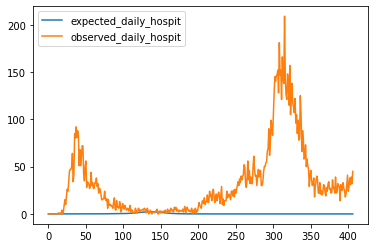

Time Step: 0, Loss: 997514.5, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 231.1869659423828
 R0:2.27962327003479, grad: -10295.4150390625, alpha: 0.0002561927249189466 grad: -211766080.0, sigma: 0.06548964232206345 grad -141983.390625
Time Step: 1, Loss: 1020566.625, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 1307.717041015625
 R0:2.27962327003479, grad: -10290.6630859375, alpha: 4.864684888161719e-05 grad: 207545872.0, sigma: 0.06548957526683807 grad 64212.4296875
Time Step: 2, Loss: 1006549.0, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 237.10763549804688
 R0:2.27962327003479, grad: 11716.095703125, alpha: 6.452013622038066e-05 grad: -15873284.0, sigma: 0.06548967957496643 grad -108017.453125
Time Step: 3, Loss: 1007566.625, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 82.56053924560547
 R0:2.27962327003479, grad: -3742.7548828125, alpha: 7.689769699936733e-05 grad: -12377562.0, sigma: 0.06548964977264404 grad 32985.33203125
Time Step: 4, L

KeyboardInterrupt: ignored

In [9]:
learning_rate = 1e-12
for t2 in range(10):

  for t in range (40):
    # forward pass - calculate expected_daily_hospit
    expected_daily_hospit = forward_pass()

    loss = (observed_daily_hospit - expected_daily_hospit).pow(2).sum()
      # for i in 1:num_obs
      #   ℓ += logpdf( NegativeBinomial2(expected_daily_hospit[i], ϕ), observed_hospit[i])
    loss -= truncnorm.logpdf(x=R0.detach().numpy() ,a=2, b=5, loc=0, scale=0.8)
    loss += truncnorm.logpdf(x=alpha.detach().numpy(),a=0 , b=5/100, loc=0, scale=1)
    loss += truncnorm.logpdf(x=sigma.detach().numpy(),a=0 , b=0.15, loc=0, scale=1)
    loss.backward()

    print(f'Time Step: {t}, Loss: {loss}, Observed_daily_hospit: {torch.sum(observed_daily_hospit)}, Expected_daily_hospit: {torch.sum(expected_daily_hospit)}')
    

    with torch.no_grad():
      #tau_t -= learning_rate * tau_t.grad
      #phi -= learning_rate * phi.grad
      R0 -= learning_rate * R0.grad
      alpha -= learning_rate * alpha.grad
      sigma -= learning_rate * sigma.grad
      print(f' R0:{R0}, grad: {R0.grad}, alpha: {alpha} grad: {alpha.grad}, sigma: {sigma} grad {sigma.grad}' )

      #tau_t.grad = None
      #phi.grad = None
      R0.grad = None
      alpha.grad = None
      sigma.grad = None
  
  
  plt.plot(expected_daily_hospit.detach().numpy(), label='expected_daily_hospit')
  plt.plot(observed_daily_hospit.detach().numpy(), label='observed_daily_hospit')
  plt.legend()
  plt.show()

compare observed hospitalizations to model results

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(expected_daily_hospit.detach().numpy(), label='expected_daily_hospit')
plt.plot(observed_daily_hospit.detach().numpy(), label='observed_daily_hospit')
plt.legend()
plt.show()